In [1]:
import sys
sys.path.append('../src')

from mcmc_norm_learning.algorithm_1_v4 import to_tuple
from mcmc_norm_learning.rules_4 import get_log_prob
from pickle_wrapper import unpickle
import pandas as pd
import yaml
import tqdm
from numpy import log

In [2]:
with open("../params_nc.yaml", 'r') as fd:
    params = yaml.safe_load(fd)

In [3]:
num_obs=params["num_observations"]
true_norm=params['true_norm']['exp']

In [4]:
num_obs

40

In [5]:
base_path="../data_nc/exp_nc3/"
exp_paths=!ls $base_path

In [6]:
def get_num_viols(nc_obs):
    n_viols=0
    for obs in nc_obs:
        for action_pairs in zip(obs, obs[1:]):
            if action_pairs[0] in [(('pickup', 8), ('putdown', 8, '1')),(('pickup', 40), ('putdown', 40, '1'))]:
                if action_pairs[1][1][2] =='1': #not in obl zone
                    n_viols+=1
                elif action_pairs[1][1][2] =='3':
                    if action_pairs[1][1][1] not in [35,13]: #permission not applicable
                        n_viols+=1
    return (n_viols)

In [25]:
z1=pd.DataFrame()
for exp_path in exp_paths:
    temp=pd.DataFrame()
    #Add params
    obs_path=base_path+exp_path+"/obs.pickle"
    obs = unpickle(obs_path)
    temp["w_nc"] = [float(exp_path.split("w_nc=")[1].split(",")[0])]
    trial=1 if "trial" not in exp_path else exp_path.split(",trial=")[-1]
    temp["trial"]=[int(trial)]
    #Add violations
    n_viols=get_num_viols(obs)
    temp["violation_rate"]=[n_viols/num_obs]
    #Add lik,post
    prior_true=!grep "For True Norm" {base_path+exp_path+"/run.log"}
    lik_true=!grep "lik_no_norm" {base_path+exp_path+"/run.log"}
    post_true=float(prior_true[0].split("log_prior=")[-1]) + float(lik_true[0].split("lik_true_norm=")[1])
    temp["true_norm_posterior"]=[post_true]
    #Add if True Norm found in some chain
    if_true_norm=!grep "True norm in some chain(s)" {base_path+exp_path+"/chain_info.txt"}
    temp["if_true_norm_found"]= ["False" not in if_true_norm[0]]
    #Rank of True Norm if found as per posterior
    rank_df=pd.read_csv(base_path+exp_path+"/ranked_posteriors.csv",index_col=False)
    rank_true=rank_df.loc[rank_df.expression==str(to_tuple(true_norm))][["post_rank","log_posterior"]].values
    rank=rank_true[0][0] if rank_true.shape[0]==1 else None
    temp["true_norm_rank_wrt_posterior"]= [rank]
    #max posterior found in chains
    rank_1=rank_df.loc[rank_df.post_rank==1]
    temp["max_posterior_in_chain"]= [rank_1.log_posterior.values[0]]
    temp["norm_wi_max_post"]= [rank_1.expression.values[0]]
    #chain summary
    chain_details = pd.read_csv(f"{base_path+exp_path}/chain_posteriors_nc.csv")
    n_chains1=chain_details.loc[chain_details.expression==str(true_norm)].chain_number.nunique()
    temp["#chains_wi_true_norm"]= [n_chains1]
    chain_max_min=chain_details.groupby(["chain_number"])[["log_posterior"]].agg(['min', 'max', 'mean', 'std'])
    n_chains2=(chain_max_min["log_posterior","max"]>post_true).sum()
    temp["#chains_wi_post_gt_true_norm"]= [n_chains2]
    #Posterior Estimation
    n=params["n"]
    top_norms=chain_details.loc[chain_details.chain_pos>2*n\
                           ].groupby(["expression"]).agg({"log_posterior":["mean","count"]})
    top_norms["chain_rank"]=top_norms[[('log_posterior', 'count')]].rank(method='dense',ascending=False)
    top_norms.sort_values(by=["chain_rank"],inplace=True)
    rank_true_wi_freq=top_norms.iloc[top_norms.index==str(true_norm)]["chain_rank"].values
    rank_true_wi_freq = float(rank_true_wi_freq[0]) if rank_true_wi_freq.size>0 else None
    temp["#rank_true_wi_freq"]= [rank_true_wi_freq]
    post_norm_top=top_norms.loc[top_norms.chain_rank==1]["log_posterior","mean"].values
    post_norm_top = post_norm_top[0] if post_norm_top.size>0 else None
    temp["posterior_norm_top"]= [post_norm_top]
    #Num equivalent norms in posterior
    log_lik=float(lik_true[0].split("lik_true_norm=")[1])
    top_norms["log_prior"]=top_norms.index.to_series().apply(lambda x: get_log_prob("NORMS",eval(x)))[0]
    top_norms["log_lik"]=top_norms[('log_posterior',  'mean')]-top_norms["log_prior"]
    mask_equiv=abs((top_norms["log_lik"]-log_lik)/log_lik)<=0.0005
    n_equiv=mask_equiv.sum()
    temp["total_equiv_norms_in_top_norms"]= [n_equiv]
    n_equiv_20=mask_equiv[:20].sum()
    temp["total_equiv_norms_in_top_20_norms"]= [n_equiv_20]
    best_equiv_norm_rank=top_norms.loc[mask_equiv]["chain_rank"].min()
    temp["best_equiv_norm_rank"]= [best_equiv_norm_rank]
    best_equiv_norm=eval(top_norms.loc[mask_equiv].index[0]) if n_equiv>0 else None
    temp["best_equiv_norm"]= [best_equiv_norm]
    z1=z1.append(temp)

In [26]:
z1.columns

Index(['w_nc', 'trial', 'violation_rate', 'true_norm_posterior',
       'if_true_norm_found', 'true_norm_rank_wrt_posterior',
       'max_posterior_in_chain', 'norm_wi_max_post', '#chains_wi_true_norm',
       '#chains_wi_post_gt_true_norm', '#rank_true_wi_freq',
       'posterior_norm_top', 'total_equiv_norms_in_top_norms',
       'total_equiv_norms_in_top_20_norms', 'best_equiv_norm_rank',
       'best_equiv_norm'],
      dtype='object')

In [44]:
z1["if_equiv_norm_found"]=z1["total_equiv_norms_in_top_norms"]>0

z1["if_true_or_equiv_norm_found"]=z1["if_equiv_norm_found"] | z1["if_true_norm_found"]

z1["true_post/max_post"]=z1["true_norm_posterior"]/z1["max_posterior_in_chain"]
z1["%chains_wi_true_norm"]=z1["#chains_wi_true_norm"]/10
z1["%chains_wi_post_gt_true_norm"]=z1["#chains_wi_post_gt_true_norm"]/10

z1["expected_violation_rate"]=z1["w_nc"]*108/243

In [45]:
z1["chk"]=z1["violation_rate"]/z1["expected_violation_rate"]

### Summary

In [28]:
print ("%trials where true norms found: {:.2%}".format(z1["if_true_norm_found"].mean()))
print ("%trials where equiv norms found: {:.2%}".format(z1["if_equiv_norm_found"].mean()))
print ("%trials where true/equiv norms found: {:.2%}".format(z1["if_true_or_equiv_norm_found"].mean()))

%trials where true norms found: 56.00%
%trials where equiv norms found: 60.00%
%trials where true/equiv norms found: 68.00%


### Where are neither True nor equivalent Norms found ?

In [89]:
z1.groupby(["chk"]).agg({"if_true_or_equiv_norm_found":"mean","trial":"count"})

,if_true_or_equiv_norm_found,trial
chk,,
0.000000,1.0,6
0.187500,0.0,1
0.225000,1.0,1
0.281250,1.0,1
0.375000,1.0,2
0.421875,1.0,2
0.482143,0.5,2
0.562500,0.5,2
0.642857,1.0,1


array([<AxesSubplot:xlabel='chk'>, <AxesSubplot:xlabel='chk'>,
       <AxesSubplot:xlabel='chk'>, <AxesSubplot:xlabel='chk'>],
      dtype=object)

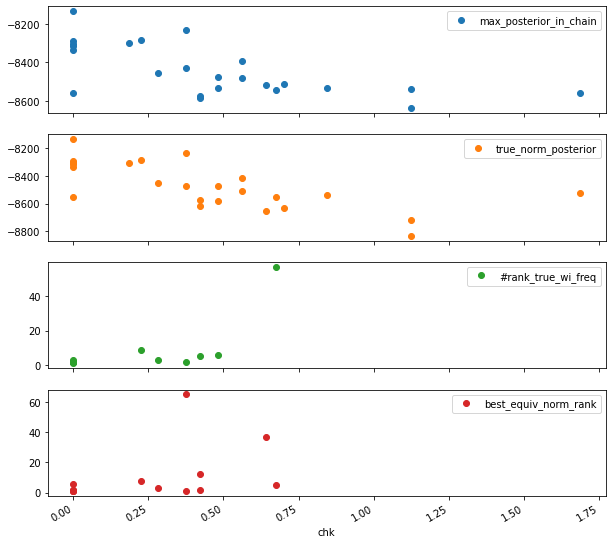

In [85]:
import matplotlib.pyplot as plt
z1.plot(x="chk",y=["max_posterior_in_chain","true_norm_posterior",\
                   "#rank_true_wi_freq","best_equiv_norm_rank"],subplots=True,\
        marker="o",kind = 'line',ls="none",figsize = (10,10))
#z1.plot(x="chk",y="true_norm_posterior",kind="scatter")

In [40]:
108/243*0.3

0.13333333333333333

In [41]:
z1.groupby(["w_nc","violation_rate"]).agg({"trial":"count","if_true_or_equiv_norm_found":"mean"})

trial  if_true_or_equiv_norm_found
w_nc violation_rate                                    
0.00 0.000               1                          1.0
0.05 0.000               3                          1.0
0.10 0.000               1                          1.0
     0.025               1                          1.0
     0.075               1                          0.0
0.15 0.000               2                          1.0
     0.025               1                          1.0
0.20 0.025               1                          1.0
     0.050               1                          0.0
     0.075               1                          0.0
0.25 0.025               1                          1.0
     0.075               1                          1.0
     0.125               1                          0.0
0.30 0.025               1                          0.0
     0.050               1                          1.0
     0.150               1                          0.0
0.35 0.075               2                          0.5
     0.100               1                          1.0
0.40 0.075               2                          1.0
     0.125               1                          0.0

In [30]:
z1.groupby(["w_nc"]).agg({"trial":"count","if_true_norm_found":[("mean")],"if_equiv_norm_found":"mean",\
                          "if_true_or_equiv_norm_found":"mean","true_norm_posterior":"mean",\
                          "true_post/max_post":"mean","%chains_wi_true_norm":"mean"})

,trial,if_true_norm_found,if_equiv_norm_found,if_true_or_equiv_norm_found,true_norm_posterior,true_post/max_post,%chains_wi_true_norm
,count,mean,mean,mean,mean,mean,mean
w_nc,,,,,,,
0.00,1,1.000000,1.000000,1.000000,-8136.321544,1.000000,0.100000
0.05,3,1.000000,1.000000,1.000000,-8244.175294,1.000000,0.300000
0.10,3,0.666667,0.333333,0.666667,-8419.778050,0.999645,0.166667
0.15,3,0.666667,1.000000,1.000000,-8375.181882,0.999800,0.233333
0.20,3,0.333333,0.333333,0.333333,-8499.649398,1.001199,0.066667
0.25,3,0.666667,0.666667,0.666667,-8518.358831,1.007094,0.066667
0.30,3,0.333333,0.333333,0.333333,-8538.682982,1.009629,0.066667
0.35,3,0.333333,0.333333,0.666667,-8568.341582,1.007124,0.033333


In [24]:
z1.dtypes

w_nc                                 float64
trial                                  int64
violation_rate                       float64
true_norm_posterior                  float64
if_true_norm_found                      bool
true_norm_rank_wrt_posterior          object
max_posterior_in_chain               float64
norm_wi_max_post                      object
#chains_wi_true_norm                   int64
#chains_wi_post_gt_true_norm           int64
#rank_true_wi_freq                    object
posterior_norm_top                   float64
total_equiv_norms_in_top_norms         int64
total_equiv_norms_in_top_20_norms      int64
best_equiv_norm_rank                 float64
best_equiv_norm                       object
if_equiv_norm_found                     bool
if_true_or_equiv_norm_found             bool
true_post/max_post                   float64
%chains_wi_true_norm                 float64
%chains_wi_post_gt_true_norm         float64
dtype: object

In [23]:
z1.groupby(["w_nc"]).mean()

,trial,violation_rate,true_norm_posterior,if_true_norm_found,max_posterior_in_chain,#chains_wi_true_norm,#chains_wi_post_gt_true_norm,posterior_norm_top,total_equiv_norms_in_top_norms,total_equiv_norms_in_top_20_norms,best_equiv_norm_rank,if_equiv_norm_found,if_true_or_equiv_norm_found,true_post/max_post,%chains_wi_true_norm,%chains_wi_post_gt_true_norm
w_nc,,,,,,,,,,,,,,,,
0.00,1.0,0.000000,-8136.321544,1.000000,-8136.321544,1.000000,0.000000,-8672.785205,3.000000,2.000000,5.000000,1.000000,1.000000,1.000000,0.100000,0.000000
0.05,2.0,0.000000,-8244.175294,1.000000,-8244.175294,3.000000,0.000000,-8381.929808,3.000000,3.000000,1.333333,1.000000,1.000000,1.000000,0.300000,0.000000
0.10,2.0,0.033333,-8419.778050,0.666667,-8422.982283,1.666667,1.333333,-8473.307342,1.000000,1.000000,1.000000,0.333333,0.666667,0.999645,0.166667,0.133333
0.15,2.0,0.008333,-8375.181882,0.666667,-8376.893078,2.333333,0.000000,-8527.879655,3.000000,2.666667,3.000000,1.000000,1.000000,0.999800,0.233333,0.000000
0.20,2.0,0.050000,-8499.649398,0.333333,-8489.464588,0.666667,1.333333,-8657.401245,1.000000,1.000000,3.000000,0.333333,0.333333,1.001199,0.066667,0.133333
0.25,2.0,0.075000,-8518.358831,0.666667,-8457.771592,0.666667,3.666667,-8586.324536,2.000000,2.000000,6.500000,0.666667,0.666667,1.007094,0.066667,0.366667
0.30,2.0,0.075000,-8538.682982,0.333333,-8456.009824,0.666667,6.000000,-8456.009824,1.000000,0.000000,65.000000,0.333333,0.333333,1.009629,0.066667,0.600000
0.35,2.0,0.083333,-8568.341582,0.333333,-8507.636655,0.333333,3.666667,-8573.770195,3.333333,0.000000,37.000000,0.333333,0.666667,1.007124,0.033333,0.366667
0.40,2.0,0.091667,-8608.261047,0.333333,-8556.565832,0.666667,5.333333,-8569.247935,3.666667,2.000000,7.000000,0.666667,0.666667,1.006063,0.066667,0.533333


In [12]:
true_norm

['Norms',
 ['Obl',
  ['Moved',
   ['Colour', 'r'],
   ['Shape', 'any'],
   ['Zone', '1'],
   ['Next-Move', ['Colour', 'any'], ['Shape', 'any']]],
  ['Zone', '2']],
 ['Per',
  ['Action', 'putdown'],
  ['Colour', 'any'],
  ['Shape', 'square'],
  ['PerZone', '3']]]

In [13]:
z1.loc[~(z1.if_true_norm_found)][["w_nc","best_equiv_norm_rank","best_equiv_norm"]].values

array([[0.1, nan, None],
       [0.15, 6.0,
        list(['Norm', ['Obl', ['Moved', ['Colour', 'r'], ['Shape', 'any'], ['Zone', '1'], ['Next-Move', ['Colour', 'b'], ['Shape', 'any']]], ['Zone', '2']]])],
       [0.2, nan, None],
       [0.2, nan, None],
       [0.25, nan, None],
       [0.3, nan, None],
       [0.3, nan, None],
       [0.35, 37.0,
        list(['Norms', ['Obl', ['Moved', ['Colour', 'any'], ['Shape', 'any'], ['Zone', '3'], ['Moved', ['Colour', 'r'], ['Shape', 'any'], ['Zone', '2'], ['Next-Move', ['Colour', 'any'], ['Shape', 'any']]]], ['Zone', '1']], ['Per', ['Action', 'putdown'], ['Colour', 'g'], ['Shape', 'square'], ['PerZone', 'any']]])],
       [0.35, nan, None],
       [0.4, nan, None],
       [0.4, 12.0,
        list(['Norm', ['Obl', ['Moved', ['Colour', 'r'], ['Shape', 'any'], ['Zone', '1'], ['Next-Move', ['Colour', 'any'], ['Shape', 'circle']]], ['Zone', '2']]])]],
      dtype=object)